# 

# ARIMA

AutoRegressive integrated moving average (ARIMA) is a kind of univariate time series forecasting model, that uses the previous values to predict future values. 

In [ ]:
#Changing working directory
import pandas as pd
import matplotlib.pyplot as plt
import os
print(os.getcwd())
import warnings
warnings.filterwarnings('ignore')

/work


In [ ]:
!pip install pmdarima
!pip install statsmodels

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
TempData = pd.read_csv('/work/Stock data/Phizer.csv')
TempData.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return
0,2019-01-02,40.910816,41.271347,40.455406,41.034157,36.581047,26430315,NaN
1,2019-01-03,41.024670,41.119545,39.800758,39.886147,35.557613,28503533,-0.027977
2,2019-01-04,40.265656,41.129032,40.094875,40.796963,36.369591,27145348,0.022836
3,2019-01-07,40.863377,41.385201,40.664139,41.015179,36.564133,20995469,0.005349
4,2019-01-08,41.328274,41.461102,40.939278,41.204933,36.733299,19677231,0.004627
...,...,...,...,...,...,...,...,...
742,2021-12-10,51.200001,52.849998,51.110001,52.779999,52.779999,26043000,0.013441
743,2021-12-13,53.439999,55.730000,53.439999,55.200001,55.200001,54923200,0.045851
744,2021-12-14,54.770000,55.950001,54.320000,55.540001,55.540001,48685700,0.006159
745,2021-12-15,56.110001,58.919998,55.889999,58.799999,58.799999,75202900,0.058696


In [ ]:
#Data Cleaning
HCLTechStockData = TempData.dropna() #making shure that there are no Nan-values that can mess up the model.


HCLTechStockData.index = pd.to_datetime(HCLTechStockData.Date) #setting the date as datetime-index.
  
HCLTechStockData = HCLTechStockData["Close"]['2019-01-01':'2022-01-01'] #the period of which the ARIMA model will be calculated of the variable 'Close'
HCLTechStockData.describe()

count    746.000000
mean      38.051967
std        4.653917
min       27.030361
25%       34.898009
50%       36.897533
75%       40.150002
max       61.250000
Name: Close, dtype: float64

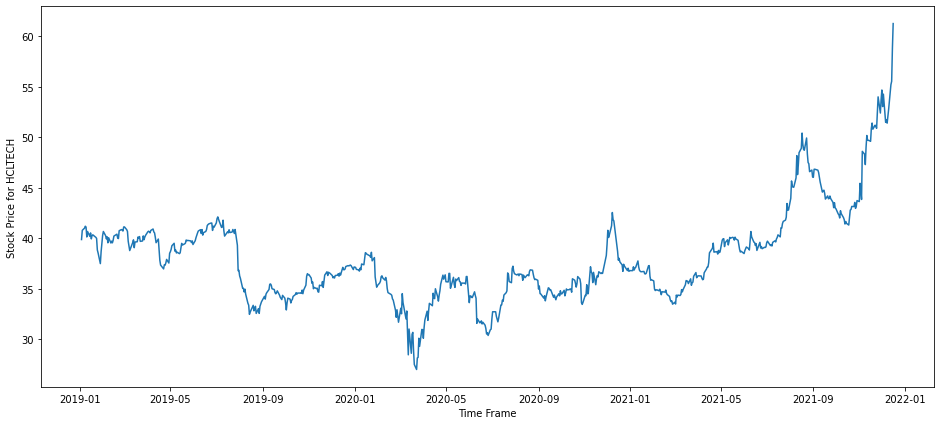

In [ ]:
#Data Exploration
plt.figure(figsize=(16,7))
fig = plt.figure(1)
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Time Frame')
ax1.set_ylabel('Stock Price for HCLTECH')
ax1.plot(HCLTechStockData)

Here the generel data can be seen - the stock price development over the years.

Then the next step is to see if the time series are stationary. Stationary means that there are no seasonal trends or differences in the time series. 
When we work with ARIMA it's a linear regression model, which means that the it uses its own lags as predcitors. This also means that they should be non-correlated.
To determine weather or not it's stationary, multiple approaches can be undertaken such as rolling statistics or the Duckey Fuller-approach.

In this case, rolling statistics are used to see if the mean and standard deviation are constant over the time series.

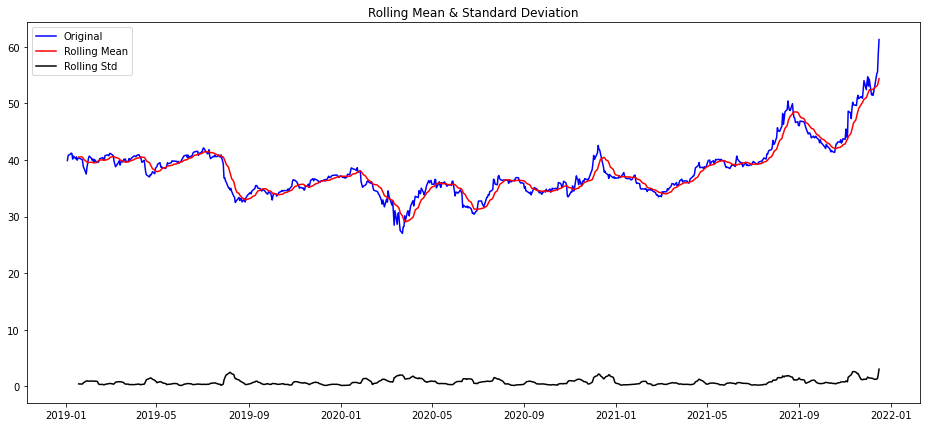

In [ ]:
#Determing rolling statistics
rolLmean = HCLTechStockData.rolling(12).mean()
rolLstd = HCLTechStockData.rolling(12).std()

plt.figure(figsize=(16,7))
fig = plt.figure(1)

#Plot rolling statistics:
orig = plt.plot(HCLTechStockData, color='blue',label='Original')
mean = plt.plot(rolLmean, color='red', label='Rolling Mean')
std = plt.plot(rolLstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

The requirement for the time series to be stationary is that they are somehow constant over time. As can be seen on the graph above is that standard deviation are somewhat constant over time, as seen by the black line. The rolling mean on the other hand is not constant as can be seen from the red line. This means that the next step will be to make it stationary. the order 'd' in ARIMA is the number of differences we need to make to make it stationary. 


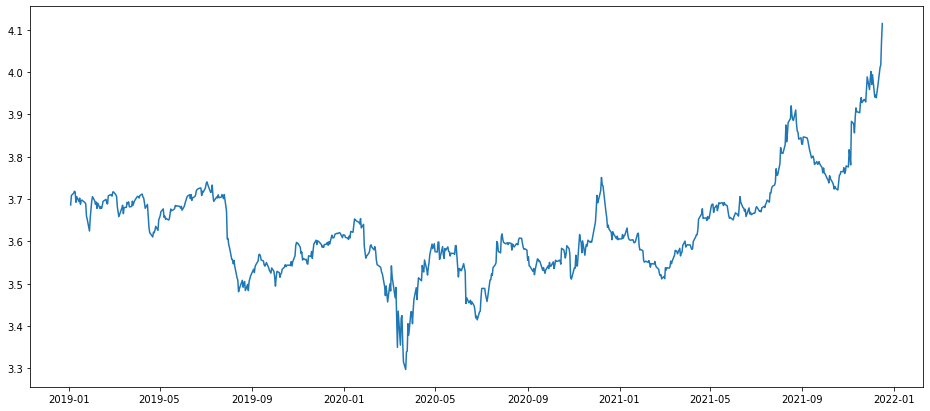

In [ ]:
#Lets try transformation
plt.figure(figsize=(16,7))
fig = plt.figure(1)

import numpy as np
ts_log = np.log(HCLTechStockData)
plt.plot(ts_log)

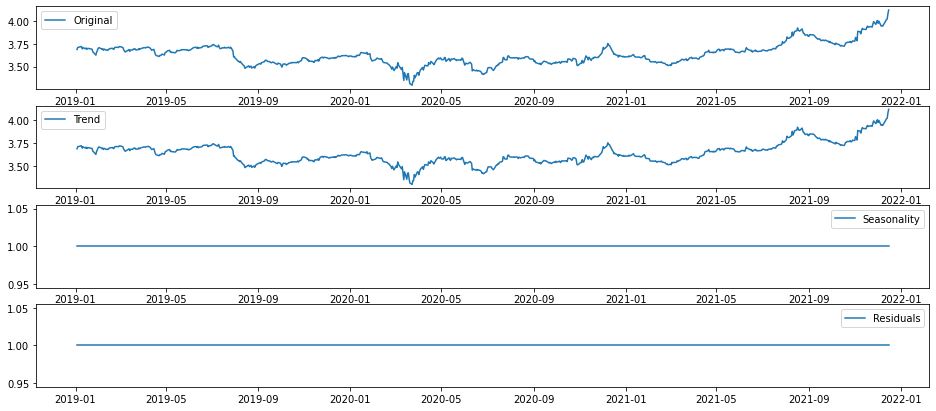

In [ ]:
#Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log,period=1,model = 'multiplicative')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(16,7))
fig = plt.figure(1)

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

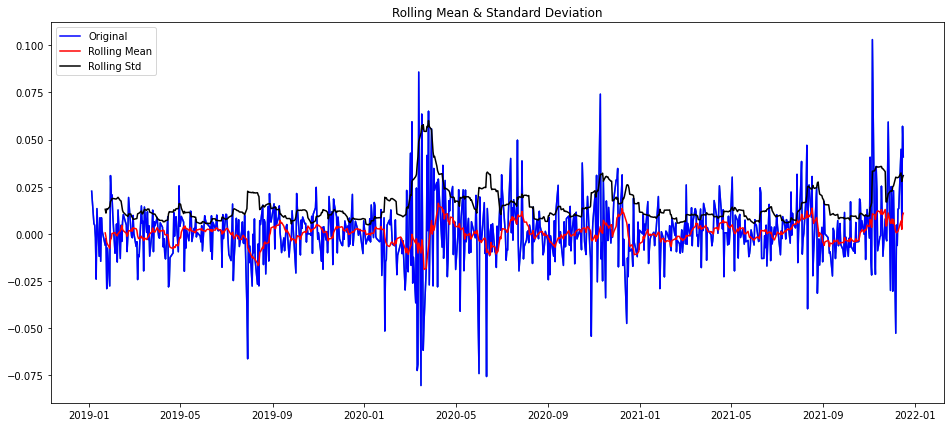

In [ ]:
#Lets try differencing
plt.figure(figsize=(16,7))
fig = plt.figure(1)
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

#Determing rolling statistics
rolLmean = ts_log_diff.rolling(12).mean()
rolLstd = ts_log_diff.rolling(12).std()




#Plot rolling statistics:
orig = plt.plot(ts_log_diff, color='blue',label='Original')
mean = plt.plot(rolLmean, color='red', label='Rolling Mean')
std = plt.plot(rolLstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

now the time series is stationary. otherwise model wil not fit well on the series.

In [ ]:
HCLTechStockData.sort_index(inplace= True)

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20)

The order p (AR) and q (MA) can be determined by the auto correlation (ACF) and partial autocorrelation (PACF) illustartion below. 

* Auto Correlation function (ACF) is the correlation between a value of a time series and previous values in the time series. 
* > Thereby we can determine q (MA). The blue area is the significance level of which the value should be above, with as few lags as possible.Therefore 1 q would be sufficient in this model.
* Partial autocorrelation function (PACF) is the correlation between the lag (previous value) and the series, where the intervening values are removed.
* > Thereby we can determine p (AR). The blue area is the significance level of which the value should be above, with as few lags as possible. Therefore 1 p would be sufficiant in this model.


so go with 1 0 1 (d starts with 0)


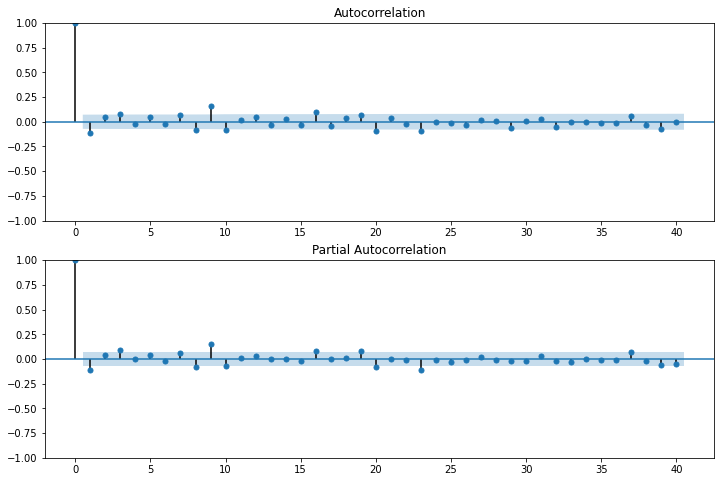

In [ ]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_log_diff.dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_log_diff.dropna(),lags=40,ax=ax2)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
type(ts_log_diff)

pandas.core.series.Series

In [ ]:
#ts_log_diff.dropna()
ts_log_diff = ts_log_diff[~ts_log_diff.isnull()]

Next the ARIMA model is build. From above we have the values of p, d, q of: (1, 1, 1)

/root/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/root/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/root/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/root/venv/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


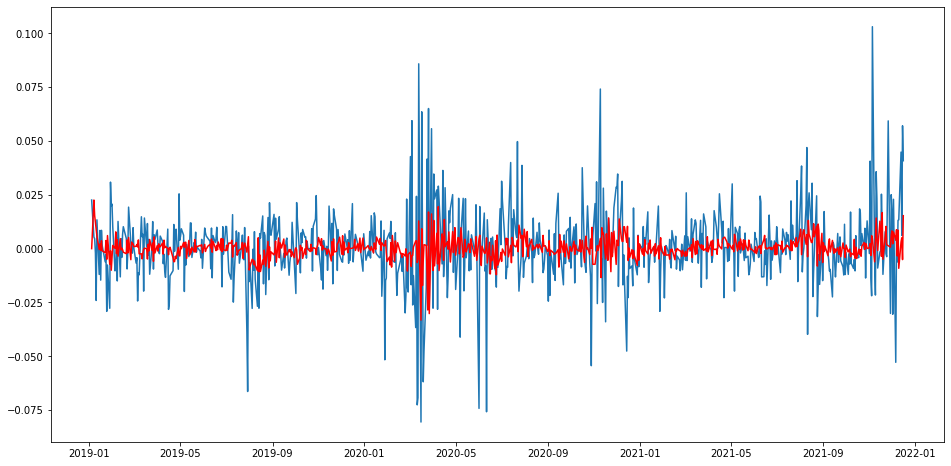

In [ ]:
plt.figure(figsize=(16,8))
#ts_log_diff.dropna(inplace=True)
model = ARIMA(ts_log_diff, order=(9,1,3))  
results_ARIMA = model.fit()  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')

Red = fittet values - predicting for the model
blue = actal values 
so how the model fits on the data

In [ ]:
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  745
Model:                 ARIMA(9, 1, 3)   Log Likelihood                1969.070
Date:                Thu, 30 Dec 2021   AIC                          -3912.140
Time:                        04:23:26   BIC                          -3852.183
Sample:                             0   HQIC                         -3889.029
                                - 745                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8006      0.259     -3.092      0.002      -1.308      -0.293
ar.L2         -0.3491      0.250     -1.395      0.163      -0.840       0.141
ar.L3          0.0897      0.060      1.498      0.134      -0.028       0.207
ar.L4          0.1074      0.062      1.743      0.081      -0.013       0.228
ar.L5          0.0887      0.057      1.564      0.118      -0.022       0.200
ar.L6          0.0304      0.053      0.570      0.568      -0.074       0.135
ar.L7          0.0649      0.046      1.416      0.157      -0.025       0.155
ar.L8         -0.0152      0.045     -0.339      0.735      -0.103       0.073
ar.L9          0.1187      0.040      2.976      0.003       0.041       0.197
ma.L1         -0.2737      0.261     -1.050      0.294      -0.785       0.237
ma.L2         -0.3743      0.131     -2.865      0.004      -0.630      -0.118
ma.L3         -0.2997      0.218     -1.377      0.169      -0.726       0.127
sigma2         0.0003   8.82e-06     33.281      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               687.96
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.68   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

now: back original scale

first we take the fittet values

In [ ]:
ARIMA_diff_predictions = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(ARIMA_diff_predictions.head())

Date
2019-01-04    0.000000
2019-01-07    0.022579
2019-01-08    0.015328
2019-01-09    0.012224
2019-01-10    0.008692
dtype: float64


next: taking the cummulative sum

In [ ]:
ARIMA_diff_predictions_cumsum = ARIMA_diff_predictions.cumsum()
print(ARIMA_diff_predictions_cumsum.head())

Date
2019-01-04    0.000000
2019-01-07    0.022579
2019-01-08    0.037907
2019-01-09    0.050131
2019-01-10    0.058823
dtype: float64


In [ ]:
ARIMA_log_prediction = pd.Series(ts_log.iloc[0], index=ts_log.index)
ARIMA_log_prediction = ARIMA_log_prediction.add(ARIMA_diff_predictions_cumsum,fill_value=0)
ARIMA_log_prediction.head()

Date
2019-01-03    3.686029
2019-01-04    3.686029
2019-01-07    3.708608
2019-01-08    3.723936
2019-01-09    3.736160
dtype: float64

reverse of log (exponential)

when run, the orange is the predicted value and blue is actual values.

RMSE: 2.9466


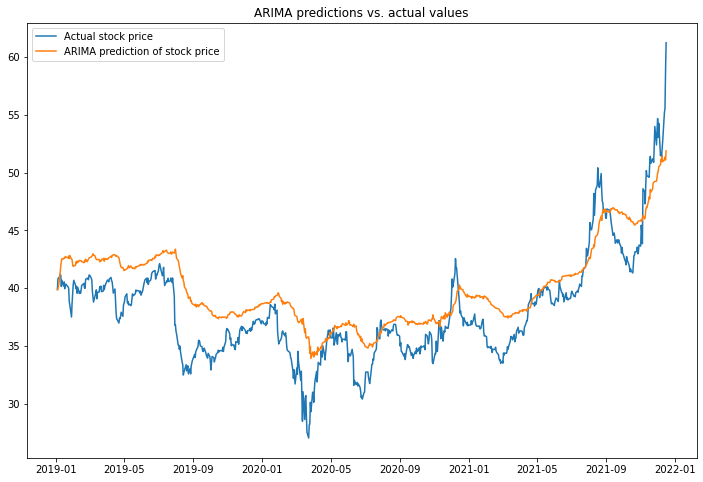

In [ ]:
plt.figure(figsize=(12,8))
predictions_ARIMA = np.exp(ARIMA_log_prediction)
plt.plot(HCLTechStockData, label='Actual stock price')
plt.plot(predictions_ARIMA, label='ARIMA prediction of stock price')
plt.title('ARIMA predictions vs. actual values')
plt.legend()
print('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-HCLTechStockData)**2)/len(HCLTechStockData)))
plt.show()

Something about the prediction.

In [ ]:
#Predict specific values (index):
results_ARIMA.predict(10,20)

Date
2019-01-18   -0.001017
2019-01-22   -0.001882
2019-01-23    0.003764
2019-01-24   -0.004941
2019-01-25    0.006077
2019-01-28   -0.007273
2019-01-29   -0.001015
2019-01-30   -0.010038
2019-01-31   -0.003897
2019-02-01    0.001509
2019-02-04    0.000112
Name: predicted_mean, dtype: float64

In [ ]:
import pmdarima as pm
def arimamodel(timeseries):
    automodel = pm.auto_arima(timeseries, 
                              start_p=1, 
                              start_q=1,
                              max_p=10,
                              max_q=10,
                              test="adf",
                              seasonal=True,
                              trace=True)
    return automodel

In [ ]:
arimamodel(ts_log)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3914.550, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3908.290, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3916.309, Time=0.35 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3915.393, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3909.486, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-3915.229, Time=0.45 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3913.514, Time=1.25 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-3917.325, Time=0.29 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-3916.296, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-3915.585, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-3916.300, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-3919.495, Time=0.83 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-3918.487, Time=0.75 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-3917.833, Time=0.98 sec
 ARIMA(1,1,2)(0,0,0

ARIMA(order=(0, 1, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

This autoArima gives the best order of the model - the best is 3,1,2

# Backtesting

In [ ]:
TempData['Date'] = pd.to_datetime(TempData['Date'])
mask = (TempData['Date'] > '2021-6-1')
TempData = TempData.loc[mask]
TempData.index = TempData['Date']
n_prediction = len(TempData['Date'] > '2021-6-1')

In [ ]:
predict_list = results_ARIMA.predict(-n_prediction)
TempData['predict'] = predict_list

In [ ]:
signals = pd.DataFrame(index=TempData.index)
signals['close'] = TempData['Adj Close']
signals['predict'] = TempData['predict']
signals = signals.reset_index()

In [ ]:
signals

,Date,close,predict
0,2021-06-02,38.107327,-0.001938
1,2021-06-03,38.284161,0.000840
2,2021-06-04,38.460991,-0.002288
3,2021-06-07,38.303810,0.001071
4,2021-06-08,38.166267,0.000507
...,...,...,...
134,2021-12-10,52.779999,-0.009135
135,2021-12-13,55.200001,0.003077
136,2021-12-14,55.540001,0.005018
137,2021-12-15,58.799999,-0.005089


In [ ]:
#Create signals when to buy the stock dependet on the predctions 

# how big should the prediction be before buy position 
#span = 0.0005
span = 0.001
#Create signal if the stock is going up by more then the span
predict_list = [0]
for x in signals['predict']:     
    if x > span:
        list = 1
        predict_list.append(list)
    elif predict_list[-1]==1:
        if x<-span:
            list1 = 1
            predict_list.append(list1)
        #else:
        #    list2 = -1
        #    predict_list.append(list2)
        else: 
            list3 = 0
            predict_list.append(list3)
    else: 
        list3 = 0
        predict_list.append(list3)

del predict_list[0]
#del predict_list[-1]
#predict_list.append(-1)
signals['signal'] = predict_list

In [ ]:
# create a new list depending on the signal 
#buy and keep aslong as the signal says 1 and change to sell -1 when the buy signal stops 
signals['positions'] = signals['signal'].diff()

#import the dates as index again
signals = signals.set_index('Date',drop=True)
#<del signals['index']

In [ ]:
print(signals.signal.value_counts())
print(signals.positions.value_counts())

1    92
0    47
Name: signal, dtype: int64
 0.0    105
 1.0     17
-1.0     16
Name: positions, dtype: int64


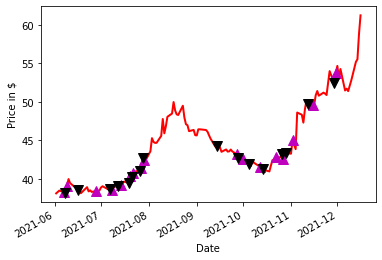

In [ ]:
# Import `pyplot` module as `plt`
import matplotlib.pyplot as plt

# Initialize the plot figure
fig = plt.figure()

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
TempData['Adj Close'].plot(ax=ax1, color='r', lw=2.)

# Plot the short and long moving averages
#signals[['short_mavg_return', 'short_mavg_predict']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.close[signals.positions == 1.0],
         '^', markersize=10, color='m')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.close[signals.positions == -1.0],
         'v', markersize=10, color='k')
         
# Show the plot
plt.show()

In [ ]:
# Set the initial capital
initial_capital= float(1000.0)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy a 100 shares
positions['PFE'] = 10*signals['signal']   
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(TempData['Adj Close'], axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(TempData['Adj Close'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(TempData['Adj Close'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

# Print the first lines of `portfolio`
print(portfolio.tail())

                   PFE    holdings        cash        total   returns
Date                                                                 
2021-12-10  527.799988  527.799988  573.657494  1101.457481  0.006396
2021-12-13  552.000008  552.000008  573.657494  1125.657501  0.021971
2021-12-14  555.400009  555.400009  573.657494  1129.057503  0.003020
2021-12-15  587.999992  587.999992  573.657494  1161.657486  0.028874
2021-12-16  612.500000  612.500000  573.657494  1186.157494  0.021091


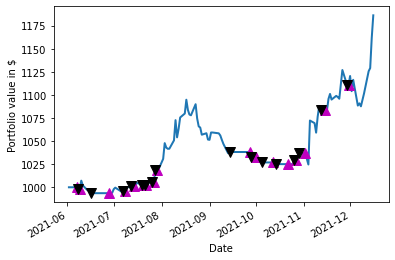

In [ ]:
# Import the `pyplot` module as `plt`
import matplotlib.pyplot as plt

# Create a figure
fig = plt.figure()

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2.)

ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m')
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k')

# Show the plot
plt.show()

# Technical analysis

In [ ]:
TempData['Date'] = pd.to_datetime(TempData['Date'])

In [ ]:
TempData['Date'] = pd.to_datetime(TempData['Date'])
mask = (TempData['Date'] > '2021-6-1')
TempData = TempData.loc[mask]
TempData.index = TempData['Date']

In [ ]:
# Initialize the short and long windows
short_window = 5
long_window = 15

# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=TempData.index)
signals['signal'] = 0.0

# Create short simple moving average over the short window
signals['short_mavg'] = TempData['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = TempData['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()

# Print `signals`
print(signals)
print(signals.signal.value_counts())
print(signals.positions.value_counts())

            signal  short_mavg  long_mavg  positions
Date                                                
2021-06-02     0.0   38.790001  38.790001        NaN
2021-06-03     0.0   38.880001  38.880001        0.0
2021-06-04     0.0   38.970001  38.970001        0.0
2021-06-07     0.0   38.975001  38.975001        0.0
2021-06-08     0.0   38.950001  38.950001        0.0
...            ...         ...        ...        ...
2021-12-10     0.0   51.892001  52.370000        0.0
2021-12-13     0.0   52.636001  52.663334        0.0
2021-12-14     1.0   53.400001  52.952667        1.0
2021-12-15     1.0   54.880000  53.467334        0.0
2021-12-16     1.0   56.714000  54.158000        0.0

[139 rows x 4 columns]
1.0    82
0.0    57
Name: signal, dtype: int64
 0.0    131
 1.0      4
-1.0      3
Name: positions, dtype: int64


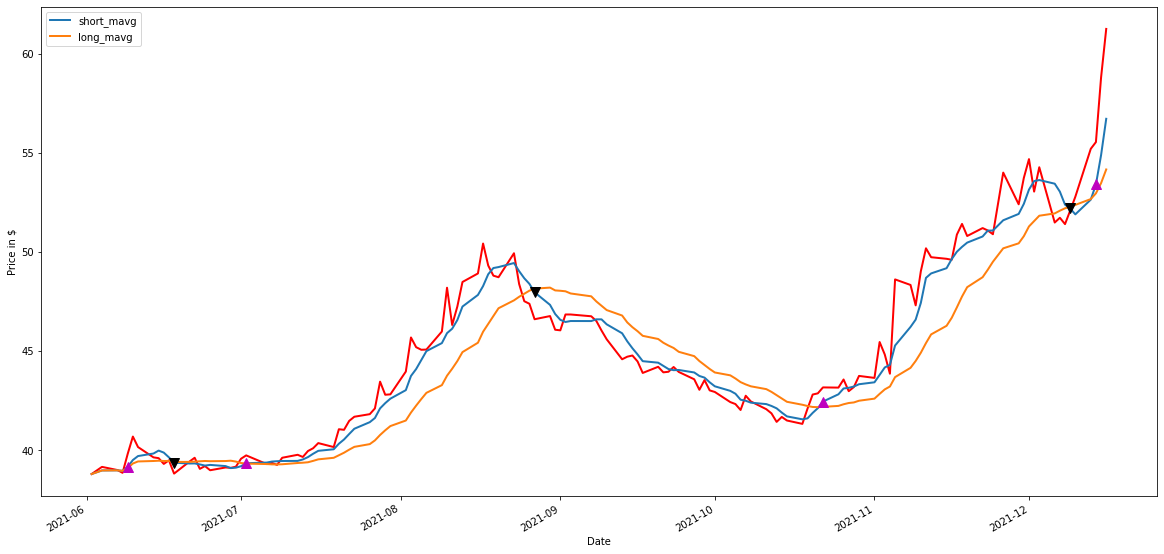

In [ ]:
# Import `pyplot` module as `plt`
import matplotlib.pyplot as plt

# Initialize the plot figure
fig = plt.figure()


# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
TempData['Close'].plot(ax=ax1, color='r', lw=2.)

# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='m')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='k')
         
# Show the plot
plt.gcf().set_size_inches(20, 10)
plt.show()

In [ ]:
# Set the initial capital
initial_capital= float(1000)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy a 100 shares
positions['PFE'] = 10*signals['signal']   
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(TempData['Close'], axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(TempData['Close'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(TempData['Close'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

# Print the first lines of `portfolio`
print(portfolio.tail())

                   PFE    holdings         cash        total   returns
Date                                                                  
2021-12-10    0.000000    0.000000  1147.900009  1147.900009  0.000000
2021-12-13    0.000000    0.000000  1147.900009  1147.900009  0.000000
2021-12-14  555.400009  555.400009   592.500000  1147.900009  0.000000
2021-12-15  587.999992  587.999992   592.500000  1180.499992  0.028400
2021-12-16  612.500000  612.500000   592.500000  1205.000000  0.020754


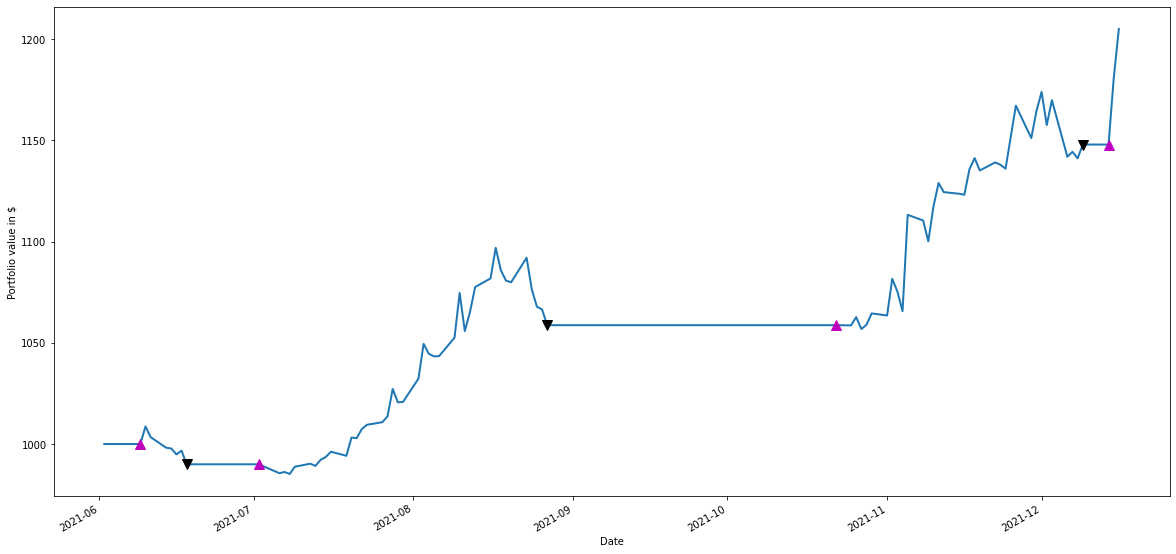

In [ ]:
# Import the `pyplot` module as `plt`
import matplotlib.pyplot as plt

# Create a figure
fig = plt.figure()

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2.)

ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m')
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k')

# Show the plot
plt.gcf().set_size_inches(20, 10)

plt.show()

In [ ]:
TempData.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,predict
Date,,,,,,,,,
2021-06-02,2021-06-02,38.639999,38.930000,38.540001,38.790001,38.107327,19629000,0.007532,-0.001938
2021-06-03,2021-06-03,38.759998,39.040001,38.630001,38.970001,38.284161,17376300,0.004640,0.000840
2021-06-04,2021-06-04,39.049999,39.500000,39.020000,39.150002,38.460991,19375300,0.004619,-0.002288
2021-06-07,2021-06-07,39.080002,39.599998,38.970001,38.990002,38.303810,24110700,-0.004087,0.001071
2021-06-08,2021-06-08,39.070000,39.110001,38.480000,38.849998,38.166267,18880300,-0.003591,0.000507


In [ ]:
#Create signals when to buy the stock dependet on the predctions 

# how big should the prediction be before buy position 
span = 0.0005

#Create signal if the stock is going up by more then the span
predict_list = [0]
for x in signals['predict']:     
    if x > span:
        list = 1
        predict_list.append(list)
    elif predict_list[-1]==1:
        if x<-0.005:
            list1 = 1
            predict_list.append(list1)
        #else:
        #    list2 = -1
        #    predict_list.append(list2)
        else: 
            list3 = 0
            predict_list.append(list3)
    else: 
        list3 = 0
        predict_list.append(list3)

del predict_list[0]
#del predict_list[-1]
#predict_list.append(-1)
signals['signal'] = predict_list

KeyError: 'predict'

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=520f7743-fdb5-41d4-ba65-deb67c6338e8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>